# Data Analytics in Network - Lab

*Professor Mohamed Cheriet*

<br>
This file contains the required codes for the Lab of the **Data Analytics in Network**. Please read the Lab instructions before executing this code. To run this code, you need to install: Anaconda Navigator, TensorFlow, and Keras on your system.
<br>


Import the required packages. The main packages are:
<br>
**pandas**: provides data structures to handle data, and functions for reading data, transforming, etc.
<br>
**matplotlib**: plotting tools and functions.
<br>
**sklearn**: provides basic machine learning tools, and traditional models such as MLP, SVR, etc.
<br>
**keras**: includes new (deep learning) algorithms such as LSTM networks.
<br>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import time

Using TensorFlow backend.


  =====================================================================================================================

The function **plot_series** plots time-series data. It needs two arguments: (i) list of time-series, and (ii) list of labes (of time-series). This function is called in the next cells.

In [4]:
# function for plotting
# plot time-series

def plot_series(series_list, label_list=None):
    
    if(len(series_list)==1):
        plt.plot(series_list[0])
        
    else:
        markers = ['-*', '-+', '-o', '-s', '-^', '-v', '-d', '-x']
        if(label_list is None):
            for i in range(len(series_list)):
                plt.plot(range(series_list[0].size), series_list[i], markers[i], label='time_series '+str(i))
        
        else:
            for i in range(len(series_list)):
                plt.plot(range(series_list[0].size), series_list[i], markers[i], label=label_list[i])
        
        plt.legend(loc='upper right', prop={'size': 14})
        
    plt.xlabel('index')
    plt.ylabel('value')
    plt.gcf().set_size_inches(16, 5)
    plt.show()

  =====================================================================================================================

The function **reconstruct** is used to create the time-series from residual values. It requires three arguments: (i) the scaler object which has been used to transform the time-series data, (ii) the previous value of the time-series (or the shifted time-series), and (iii) the residual values.

In [5]:
# function for reconstructing the time-series from residuals
# This method will be employed to reconstruct the time-series from predicted values

def reconstruct(scaler, pre, prd):
    if(pre.size != prd.size):
        print('Lengths of the arguments (time-series) are not the same.')
        return None
    
    tmp1 = pre.values.reshape(pre.size, 1) + prd.reshape(pre.size, 1)
    tmp2 = scaler.inverse_transform(tmp1)
    
    reconstructed_ts = pd.DataFrame()
    reconstructed_ts['RECONST'] = tmp2[0:, 0]
    
    return reconstructed_ts

  =====================================================================================================================

Load the time-series data. We will use **pandas** package to read the data file. The variable **data** is an instance of the **DataFrame** class. You can create a new cell and try the following commands to see its content:
<br>
data.head()
<br>
or
<br>
data.iloc[0:20]
<br>
Also you can use the following command to see the size of data (number of values in data):
<br>
data.shape
<br>
The original time-series is saved in a column of DataFrame called **ORIGINAL**. We called the function plot_series to plot data. This data consists bandwidth samples (bit-rates) on a link of the Abilene network.

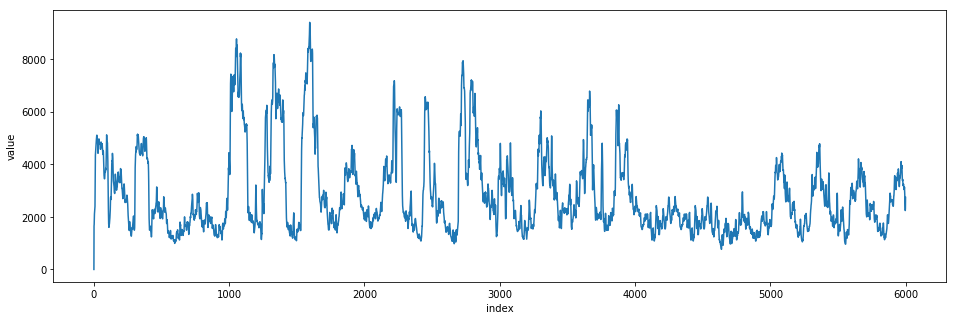

In [6]:
# load time-series data
data = pd.read_csv('time_series.csv', header=None)
data.columns = ['DATA']
plot_series([data['DATA']])

  =====================================================================================================================

The range of values in data is [~0, ~9000]. In many machine learning models, the range of values must be [-1, +1] (why?). We use the MinMaxScaler in preprocessing module of sklearn to change the range of values. The transformed values is assigned to a new column called **SCALED**. In the next cells, we will use the object **scaler** to perform inverse transform.

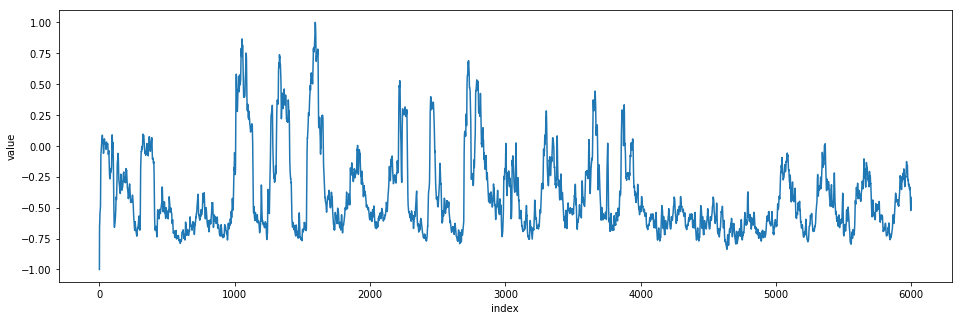

In [7]:
# data transformation - part 1
# scale the values, range of scaled version:[-1, +1]

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

data['SCALED'] = scaler.fit_transform(data['DATA'].values.reshape(data.shape[0], 1))
plot_series([data['SCALED']])

  =====================================================================================================================

The second transformation is difference operator. We use the diff function to apply the difference operator. The result is called the **residual** values which are asssigned to the column **DIFF**.

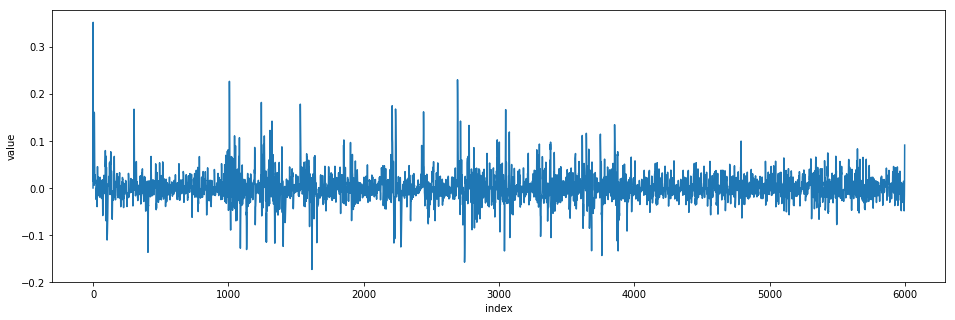

In [8]:
# data transformation - part 2
# Apply the difference operator

data['DIFF'] = data['SCALED'].diff().fillna(0)
plot_series([data['DIFF']])

  =====================================================================================================================

Create a dataset including train and test sets.
<br>
The key point is feature selection. We use previous residual values as the features. In this code, we select the 5 previous samples.
<br>
Then, we create a train set and a test set. We need to determine number of samples in each set.

In [9]:
# Prepare the dataset - part 1
# select features and label values

data['SCALED_SHIFT'] = data['SCALED'].shift(1).fillna(0)

feature_dimension = 5
for i in range(1, feature_dimension+1):
    data['FEATURE_'+str(i)] = data['DIFF'].shift(i).fillna(0)

data['LABEL'] = data['DIFF']



# Prepare the dataset - part 2
# Create train and test dataset

split_index = 3000
train_num = 1500
test_num = 500

features = ['FEATURE_'+str(i) for i in range(1, feature_dimension+1)]

label = 'LABEL'

train_x = data[features].iloc[split_index-train_num:split_index]
train_y = data[label].iloc[split_index-train_num:split_index]

test_x = data[features].iloc[split_index:split_index+test_num]
test_y = data[label].iloc[split_index:split_index+test_num]
test_pre = data['SCALED_SHIFT'].iloc[split_index:split_index+test_num]
test_orig = data['DATA'].iloc[split_index:split_index+test_num]

print('Dataset created. Number of training samples: ' + str(train_num) + '. Number of test samples: ' + str(test_num))
data.head(10)

Dataset created. Number of training samples: 1500. Number of test samples: 500


,DATA,SCALED,DIFF,SCALED_SHIFT,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,LABEL
0,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1649.600000,-0.648763,0.351237,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.351237
2,1715.250000,-0.634785,0.013978,-0.648763,0.351237,0.000000,0.000000,0.000000,0.000000,0.013978
3,1965.000000,-0.581608,0.053177,-0.634785,0.013978,0.351237,0.000000,0.000000,0.000000,0.053177
4,2107.187500,-0.551333,0.030275,-0.581608,0.053177,0.013978,0.351237,0.000000,0.000000,0.030275
5,2172.712500,-0.537381,0.013952,-0.551333,0.030275,0.053177,0.013978,0.351237,0.000000,0.013952
6,2274.740625,-0.515657,0.021724,-0.537381,0.013952,0.030275,0.053177,0.013978,0.351237,0.021724
7,2301.012500,-0.510063,0.005594,-0.515657,0.021724,0.013952,0.030275,0.053177,0.013978,0.005594
8,2399.402344,-0.489114,0.020949,-0.510063,0.005594,0.021724,0.013952,0.030275,0.053177,0.020949
9,3153.574219,-0.328534,0.160580,-0.489114,0.020949,0.005594,0.021724,0.013952,0.030275,0.160580


In [28]:
# Calculating ACF for all of the variables
acf_data = [data['DATA'].autocorr(lag) for lag in range(101)]
acf_diff = [data['DIFF'].autocorr(lag) for lag in range(101)]
acf_scaled = [data['SCALED'].autocorr(lag) for lag in range(101)]

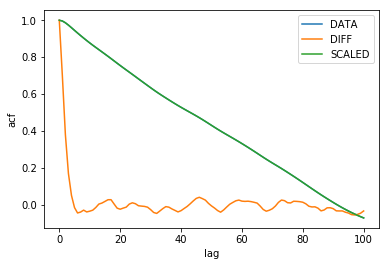

In [31]:
plt.plot(acf_data, label='DATA')
plt.plot(acf_diff, label='DIFF')
plt.plot(acf_scaled, label='SCALED')
plt.xlabel('lag')
plt.ylabel('acf')
plt.legend()
plt.show()

In [43]:
index = 0
for value in acf_diff:
    if value <= 0.005:
        print(index)
        break
    index += 1

5


  =====================================================================================================================

First Model: Multi-Layer Perceptron (MLP or Feedforward Neural Network)
<br>
1- Define the model
<br>
2- Fit the model on the training set
<br>
3- Predict the test samples
<br>
4- Evaluate the test error (we will use MSE and NMSE)

0.1655 seconds for training MLP
MSE (differnce): 0.0011961122601448517
MSE (original): 26383.340576628478
NMSE (differnce): 1.0897557103551714
NMSE (original): 0.021819400054055988


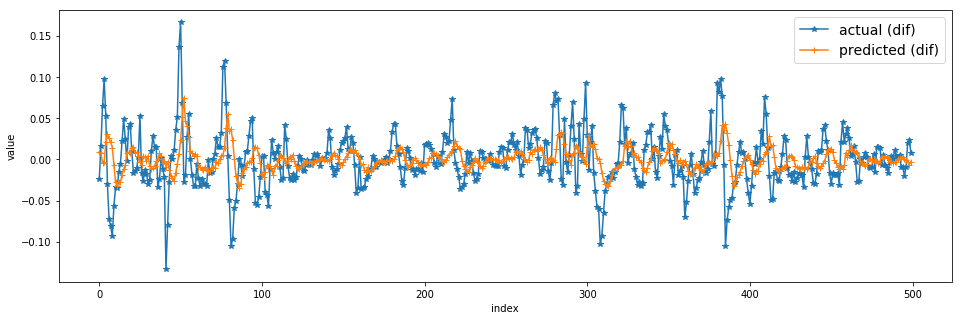

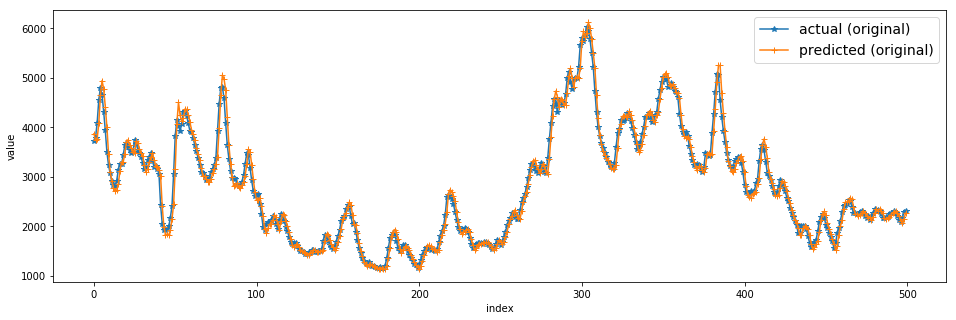

In [8]:
# The first model: Multi-Layer Perceptron (MLP)
# Modeling and Prediction using MLP

# Train the model
t1 = time.time()

reg = MLPRegressor(hidden_layer_sizes=(18, 12, 5), solver='sgd')
reg.fit(train_x, train_y)

t2 = time.time()
t = (t2-t1)
print('{0:0.4f}'.format(t) + ' seconds for training MLP')

# Predict test samples
prd_mlp = reg.predict(test_x)

# Reconstruct the time-series from residuals
rec_mlp = reconstruct(scaler, test_pre, prd_mlp)

# Evaluate the model (calculate the test error MSE)
mse_dif_mlp = mean_squared_error(test_y, prd_mlp)
mse_orig_mlp = mean_squared_error(test_orig, rec_mlp)
print('MSE (differnce): ' + str(mse_dif_mlp))
print('MSE (original): ' + str(mse_orig_mlp))

# Evaluate the model (calculate the test error NMSE)
nmse_dif_mlp = mse_dif_mlp/np.var(test_y)
nmse_orig_mlp = mse_orig_mlp/np.var(test_orig)
print('NMSE (differnce): ' + str(nmse_dif_mlp))
print('NMSE (original): ' + str(nmse_orig_mlp))

# Plot the results
plot_series([test_y, prd_mlp], ['actual (dif)', 'predicted (dif)'])
plot_series([test_orig, rec_mlp], ['actual (original)', 'predicted (original)'])

  =====================================================================================================================

The second Model: Support Vector Regressor (SVR)

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.0138 seconds for training SVR
MSE (differnce): 0.0005898527676796057
MSE (original): 13010.723974916302
NMSE (differnce): 0.5374039237502747
NMSE (original): 0.010760054837524067


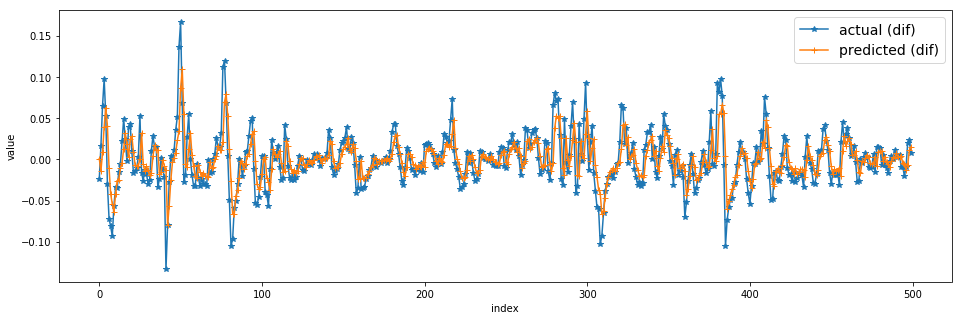

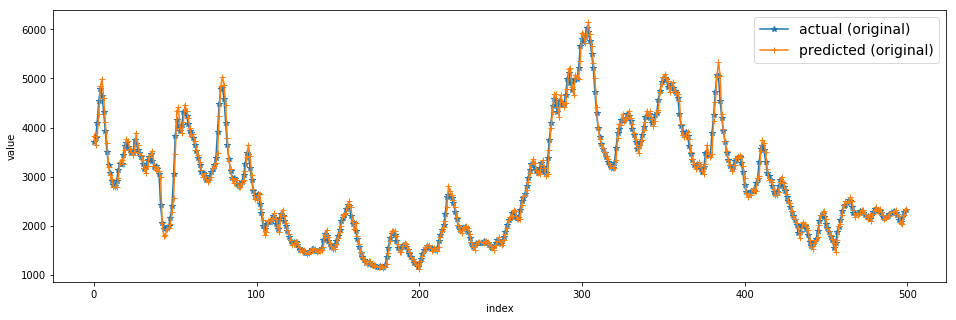

In [12]:
# The second model: Support Vector Regressor (SVR)
# Modeling and Prediction using SVR

# Train the model
t1 = time.time()

reg = SVR(kernel='rbf', epsilon=0.05)
reg.fit(train_x, train_y)

t2 = time.time()
t = (t2-t1)
print('{0:0.4f}'.format(t) + ' seconds for training SVR')

# Predict test samples
prd_svr = reg.predict(test_x)

# Reconstruct the time-series from residuals
rec_svr = reconstruct(scaler, test_pre, prd_svr)

# Evaluate the model (calculate the test error MSE)
mse_dif_svr = mean_squared_error(test_y, prd_svr)
mse_orig_svr = mean_squared_error(test_orig, rec_svr)
print('MSE (differnce): ' + str(mse_dif_svr))
print('MSE (original): ' + str(mse_orig_svr))

# Evaluate the model (calculate the test error NMSE)
nmse_dif_svr = mse_dif_svr/np.var(test_y)
nmse_orig_svr = mse_orig_svr/np.var(test_orig)
print('NMSE (differnce): ' + str(nmse_dif_svr))
print('NMSE (original): ' + str(nmse_orig_svr))

# Plot the results
plot_series([test_y, prd_svr], ['actual (dif)', 'predicted (dif)'])
plot_series([test_orig, rec_svr], ['actual (original)', 'predicted (original)'])

  =====================================================================================================================

The third model: Long Short-Term Memory (LSTM)

69.0857 seconds for training LSTM
MSE (differnce): 0.0004918041624846708
MSE (original): 10848.00912772622
NMSE (differnce): 0.44807365688167794
NMSE (original): 0.008971458722614754


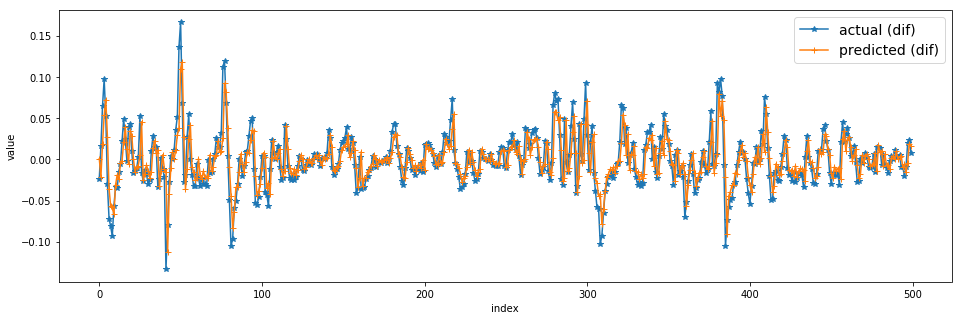

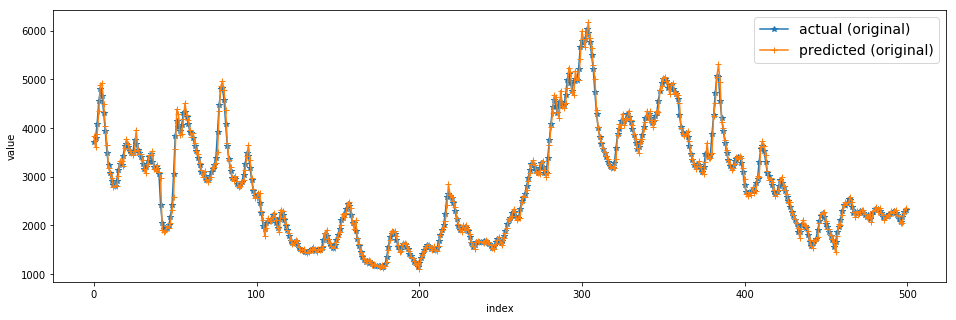

In [22]:
# The third model: Long Short-Term Memory (LSTM)
# Modeling and Prediction using LSTM

# Reshape the data for LSTM model
train_lstm_x = train_x.values.reshape(train_x.shape[0], 1, train_x.shape[1])
test_lstm_x = test_x.values.reshape(test_x.shape[0], 1, test_x.shape[1])

# Train the model
t1 = time.time()

neurons = 900
batch_size = train_num
epochs = 200

reg_lstm = Sequential()
reg_lstm.add(LSTM(neurons, input_shape=(train_lstm_x.shape[1], train_lstm_x.shape[2])))
reg_lstm.add(Dense(1))
reg_lstm.compile(loss='mean_squared_error', optimizer='adam')
reg_lstm.fit(train_lstm_x, train_y, epochs=epochs, batch_size=batch_size, shuffle=False,
             verbose=0, validation_data=(test_lstm_x, test_y))

t2 = time.time()
t = (t2-t1)
print('{0:0.4f}'.format(t) + ' seconds for training LSTM')

# Predict test samples
prd_lstm = reg_lstm.predict(test_lstm_x, batch_size=batch_size)

# Reconstruct the time-series from residuals
rec_lstm = reconstruct(scaler, test_pre, prd_lstm)

# Evaluate the model (calculate the test error MSE)
mse_dif_lstm = mean_squared_error(test_y, prd_lstm)
mse_orig_lstm = mean_squared_error(test_orig, rec_lstm)
print('MSE (differnce): ' + str(mse_dif_lstm))
print('MSE (original): ' + str(mse_orig_lstm))

# Evaluate the model (calculate the test error NMSE)
nmse_dif_lstm = mse_dif_lstm/np.var(test_y)
nmse_orig_lstm = mse_orig_lstm/np.var(test_orig)
print('NMSE (differnce): ' + str(nmse_dif_lstm))
print('NMSE (original): ' + str(nmse_orig_lstm))

# Plot the results
plot_series([test_y, prd_lstm], ['actual (dif)', 'predicted (dif)'])
plot_series([test_orig, rec_lstm], ['actual (original)', 'predicted (original)'])

  =====================================================================================================================

Comparison: plot the results

In [ ]:
# Comparison - Plotting results

plot_series([test_y[-50:], prd_mlp[-50:], prd_svr[-50:], prd_lstm[-50:]], 
            ['actual (dif)', 'MLP', 'SVR', 'LSTM'])
plot_series([test_orig[-50:], rec_mlp[-50:], rec_svr[-50:], rec_lstm[-50:]], 
            ['actual (original)', 'MLP', 'SVR', 'LSTM'])

  =====================================================================================================================

Comparison: Evaluation Metrics

In [ ]:
# Comparison - Error metrics

print('Comparing the results of different models on the transformed time-series (difference):')
print('MSE:      MLP: ' + str(mse_dif_mlp) + ',   SVR: ' + str(mse_dif_svr) + ',   LSTM: ' + str(mse_dif_lstm))
print('NMSE:     MLP: ' + str(nmse_dif_mlp) + ',   SVR: ' + str(nmse_dif_svr) + ',   LSTM: ' + str(nmse_dif_lstm))


print('\n\nComparing the results of different models considering the original time-series:')
print('MSE:      MLP: ' + str(mse_orig_mlp) + ',   SVR: ' + str(mse_orig_svr) + ',   LSTM: ' + str(mse_orig_lstm))
print('NMSE:     MLP: ' + str(nmse_orig_mlp) + ',   SVR: ' + str(nmse_orig_svr) + ',   LSTM: ' + str(nmse_orig_lstm))